# 3D Signal Visualization

## Table of Contents  

1. [Loading and Preparing Motion Capture Data](#1--loading-the-data)  
   - [1.1 Defining the Joint Class](#11--defining-the-joint-class)  
   - [1.2 Custom ASF Parser](#12--custom-asf-parser)  
   - [1.3 Custom AMC Parser](#13--custom-amc-parser)  
   - [1.4 Loading ASF/AMC Files](#14--load-the-files)  

2. [Skeleton Visualization](#2--skeleton-visualization)  
   - [2.1 Subject 1 Trial 1 Visualization](#21--subject-1-trial-1-visualization)  
   - [2.2 Subject 2 Trial 4 Visualization](#22--subject-2-trial-4-visualization)  
   - [2.3 3D Skeleton Animation](#23--3d-skeleton-animation)

3. [Skeleton 3D Animation](#3--skeleton-3d-animation)

4. [Movement Video Display](#4--movement-video-display)  
   - [4.1 Subject 1 Trial 1 Video](#41--subject-1-trial-1-video)  
   - [4.2 Subject 2 Trial 4 Video](#42-subject-2-trial-4-video)  

5. [Motion Dashboard](#5--motion-dashboard)  
   - [5.1 Video Plot Integration](#51--video-plot)  
   - [5.2 Skeleton Plot Overlay](#52--skeleton-plot)  
   - [5.3 Timeseries Motion Analysis](#53--timeseries-plot)  
   - [5.4 Main Mocap Dashboard Function](#54--main-mocap-dashboard-function)  


This notebook demonstrates how to read, process and interactively visualize 3D motion capture data in sync with its original video footage. We will work with the CMU MoCap Database and cover two main workflows:

1. **Data Loading & Basic Rendering**  
   • Load and parse Acclaim ASF/AMC skeleton (`.asf`) and motion (`.amc`) files for  
   &nbsp;&nbsp;&nbsp;&nbsp;• Subject 1, Trial 1  
   &nbsp;&nbsp;&nbsp;&nbsp;• Subject 2, Trial 4  
   • Display a single‐frame 3D skeleton to verify joint hierarchies  
   • Play back the corresponding `.mpg` video alongside the skeleton view  

2. **Dynamic Synchronized Dashboard**  
   • Create a live dashboard combining:  
   &nbsp;&nbsp;&nbsp;&nbsp;– Rotating 3D skeleton animation  
   &nbsp;&nbsp;&nbsp;&nbsp;– Original video playback  
   &nbsp;&nbsp;&nbsp;&nbsp;– Time‐series plots of selected marker coordinates (e.g. head, wrists)  
   • Add interactive slider and play controls to scrub through frames in perfect sync  
---

**Getting started:**  
Run the following cell to install any dependencies.  
```bash
pip install -r requirements.txt


## 1- Loading the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from transforms3d.euler import euler2mat
from mpl_toolkits.mplot3d import Axes3D
import cv2
from IPython.display import display, clear_output, HTML
from matplotlib import animation
from IPython.display import Video
from base64 import b64encode
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
import matplotlib.gridspec as gridspec
import matplotlib as mpl

mpl.rcParams['animation.embed_limit'] = 200  # Set to 50MB

- Allow jupyter notebook to use 200MB of memory instead of a limit of 20MB per block as it's default.  This will be extremely useful as we use animations that contain a large amount of frames.

In [2]:
# for visualizing the 3D plots, switch to 'widget' for interacting with the dashboard
%matplotlib inline

These are the data directories we have, make sure they match before executing the rest of the notebook.

In [3]:
asf_path1, asf_path2="data/01.asf", "data/02.asf"
amc_path1, amc_path2 = "data/01_01.amc", "data/02_04.amc"
mpeg_path1, mpeg_path2 = "data/01_01.mpg", "data/02_04.mpg"	

Our method for parsing AMC files was inspired by the [AMC parser GitHub library](https://github.com/CalciferZh/AMCParser), which helped us better understand the data format. A big thanks as well to our classmate Miss Khaoula Mejhoudi for pointing us toward a tricky part in the 3D visualization process. We've since reworked the code and adapted it to fit the needs of our own project.

### 1.1- Defining the Joint Class

In [4]:
class Joint:
    def __init__(self, name, direction, length, axis, dof, limits):
        self.name = name
        self.direction = np.reshape(direction, [3, 1])
        self.length = length
        axis = np.deg2rad(axis)
        self.C = euler2mat(*axis)
        self.Cinv = np.linalg.inv(self.C)
        self.limits = np.zeros([3, 2])
        for lm, nm in zip(limits, dof):
            if nm == 'rx':
                self.limits[0] = lm
            elif nm == 'ry':
                self.limits[1] = lm
            else:
                self.limits[2] = lm
        self.parent = None
        self.children = []
        self.coordinate = None
        self.matrix = None

    def set_motion(self, motion):
        if self.name == 'root':
            self.coordinate = np.reshape(np.array(motion['root'][:3]), [3, 1])
            rotation = np.deg2rad(motion['root'][3:])
            self.matrix = self.C.dot(euler2mat(*rotation)).dot(self.Cinv)
        else:
            idx = 0
            rotation = np.zeros(3)
            for axis, lm in enumerate(self.limits):
                if not np.array_equal(lm, np.zeros(2)):
                    rotation[axis] = motion[self.name][idx]
                    idx += 1
            rotation = np.deg2rad(rotation)
            self.matrix = self.parent.matrix.dot(self.C).dot(
                euler2mat(*rotation)).dot(self.Cinv)
            self.coordinate = self.parent.coordinate + \
                self.length * self.matrix.dot(self.direction)
        for child in self.children:
            child.set_motion(motion)

    def draw(self):
        joints = self.to_dict()
        fig = plt.figure()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)

        ax.set_xlim3d(-50, 10)
        ax.set_ylim3d(-20, 40)
        ax.set_zlim3d(-20, 40)

        xs, ys, zs = [], [], []
        for joint in joints.values():
            xs.append(joint.coordinate[0, 0])
            ys.append(joint.coordinate[1, 0])
            zs.append(joint.coordinate[2, 0])
        plt.plot(zs, xs, ys, 'b.')

        for joint in joints.values():
            child = joint
            if child.parent is not None:
                parent = child.parent
                xs = [child.coordinate[0, 0], parent.coordinate[0, 0]]
                ys = [child.coordinate[1, 0], parent.coordinate[1, 0]]
                zs = [child.coordinate[2, 0], parent.coordinate[2, 0]]
                plt.plot(zs, xs, ys, 'r')
        plt.show()

    def to_dict(self):
        ret = {self.name: self}
        for child in self.children:
            ret.update(child.to_dict())
        return ret

### 1.2- Custom ASF Parser

In [5]:
# helper functions to setup the parsing
def parse_joint_block(content, start_idx):
    joint = {}
    while True:
        line = content[start_idx].strip().split()
        start_idx += 1
        key = line[0]
        if key == 'end':
            break
        handlers = {
            'name': lambda l: joint.update({'name': l[1]}),
            'direction': lambda l: joint.update({'direction': list(map(float, l[1:]))}),
            'length': lambda l: joint.update({'length': float(l[1])}),
            'axis': lambda l: joint.update({'axis': list(map(float, l[1:-1]))}),
            'dof': lambda l: joint.update({'dof': l[1:]}),
            'limits': lambda l: joint.setdefault('limits', []).append(
                list(map(float, ' '.join(l[1:]).replace('(', '').replace(')', '').split()))
            )
        }
        if key in handlers:
            handlers[key](line)
    return joint, start_idx

def read_section_after(content, keyword):
    return content[content.index(keyword) + 1:]

def parse_hierarchy(content, idx, joints):
    while content[idx].strip().split()[0] != 'begin':
        idx += 1
    idx += 1
    while content[idx].strip().split()[0] != 'end':
        line = content[idx].strip().split()
        idx += 1
        parent = joints[line[0]]
        for child_name in line[1:]:
            child = joints[child_name]
            parent.children.append(child)
            child.parent = parent
    return joints


# main function for parsing
def parse_asf(file_path):
    with open(file_path) as f:
        content = f.read().splitlines()

    content = read_section_after(content, ':bonedata')
    joints = {'root': Joint('root', np.zeros(3), 0, np.zeros(3), [], [])}

    idx = 0
    while idx < len(content):
        line = content[idx].strip().split()
        idx += 1
        if line[0] == ':hierarchy':
            break
        if line[0] != 'begin':
            continue

        joint_data, idx = parse_joint_block(content, idx)
        joints[joint_data['name']] = Joint(
            joint_data['name'],
            joint_data['direction'],
            joint_data['length'],
            joint_data['axis'],
            joint_data.get('dof', []),
            joint_data.get('limits', [])
        )

    return parse_hierarchy(content, idx, joints)

### 1.3- Custom AMC Parser

In [6]:
def parse_amc(file_path):
    with open(file_path) as f:
        content = f.read().splitlines()

    content = content[content.index(':DEGREES') + 1:]
    frames = []
    idx = 0
    current_frame = {}

    while idx < len(content):
        line = content[idx].strip().split()
        idx += 1
        if not line:
            continue
        if line[0].isnumeric():
            if current_frame:
                frames.append(current_frame)
                current_frame = {}
        else:
            current_frame[line[0]] = list(map(float, line[1:]))

    if current_frame:
        frames.append(current_frame)

    return frames

### 1.4- Load the Files

In [7]:
joints1, joints2 = parse_asf(asf_path1), parse_asf(asf_path2)
motions1, motions2 = parse_amc(amc_path1),parse_amc(amc_path2)

## 2- Skeleton Visualization

We will now work on visualizing the 3D human skeleton model with customizable display options. 

The function `visualize_skeleton`:
- Preserves the original visualization style and dimensions
- Optionally shows joint labels
- Supports animation through motion data frames
- Maintains consistent camera perspective and scaling

🛠 **Parameters**

| Parameter | Type | Default | Description |
|-----------|------|---------|-------------|
| `joints` | dict | Required | Dictionary containing skeleton joints (must include 'root' joint) |
| `show_labels` | bool | `False` | Whether to display joint name labels |
| `motion_data` | list | `None` | List of motion frames (parsed AMC data) |
| `motion_frame` | int | `0` | Index of specific motion frame to visualize |


In [8]:
def visualize_skeleton(joints, show_labels=False, motion_data=None, motion_frame=0):

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    import copy
    current_joints = copy.deepcopy(joints)

    if motion_data is not None and motion_frame < len(motion_data):
        current_joints['root'].set_motion(motion_data[motion_frame])

    joint_dict = current_joints['root'].to_dict()
    xs, ys, zs = [], [], []
    for joint in joint_dict.values():
        xs.append(joint.coordinate[0, 0])
        ys.append(joint.coordinate[1, 0])
        zs.append(joint.coordinate[2, 0])

    ax.scatter(zs, xs, ys, c='b', marker='o', s=50)

    if show_labels:
        for joint in joint_dict.values():
            ax.text(joint.coordinate[2, 0],
                    joint.coordinate[0, 0],
                    joint.coordinate[1, 0],
                    joint.name, fontsize=8)

    for joint in joint_dict.values():
        if joint.parent:
            parent = joint.parent
            ax.plot([joint.coordinate[2, 0], parent.coordinate[2, 0]],
                    [joint.coordinate[0, 0], parent.coordinate[0, 0]],
                    [joint.coordinate[1, 0], parent.coordinate[1, 0]], 'r-')

    ax.set_xlabel('Z')
    ax.set_ylabel('X')
    ax.set_zlabel('Y')
    ax.set_title(f'Skeleton Visualization{"" if motion_data is None else f" - Frame {motion_frame}"}')

    ax.set_box_aspect([1, 1, 1])

    plt.show()

### 2.1- Subject 1 Trial 1 Visualization

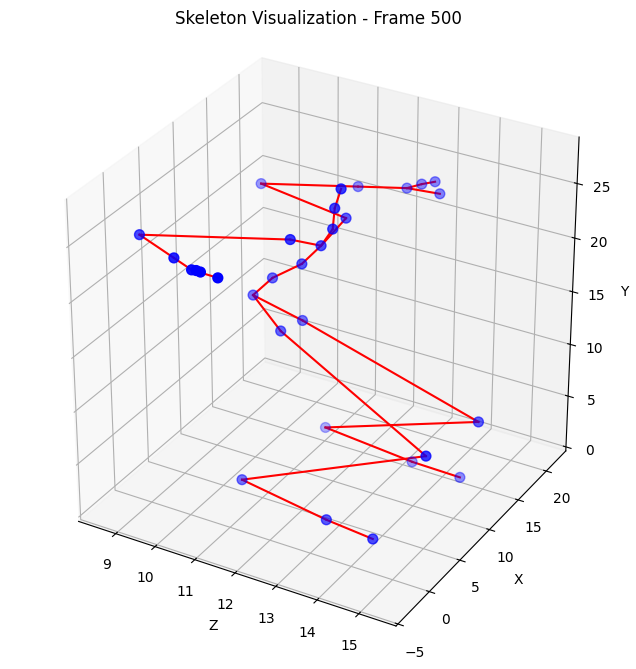

In [9]:
visualize_skeleton(joints1, motion_data=motions1, motion_frame=500)

We can observe here the posture before the horizontal jump.

Let's do another test for another motion frame.

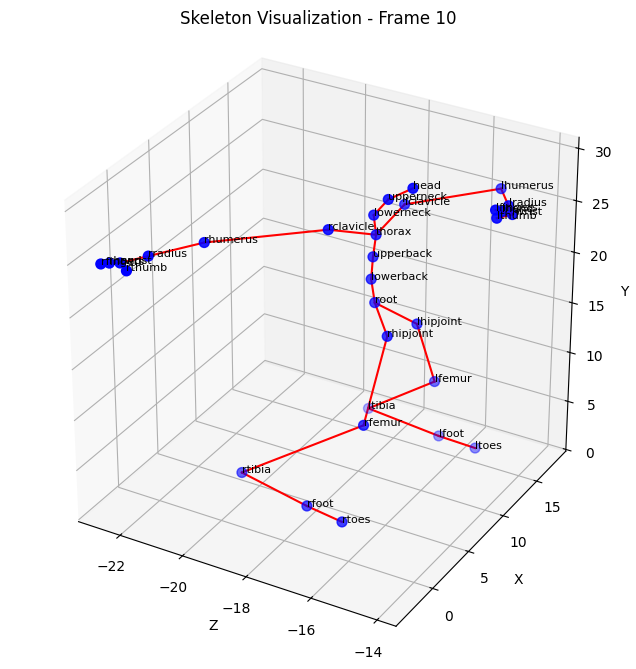

In [10]:
visualize_skeleton(joints1, show_labels=True, motion_data=motions1, motion_frame=10)

### 2.2- Subject 2 Trial 4 Visualization

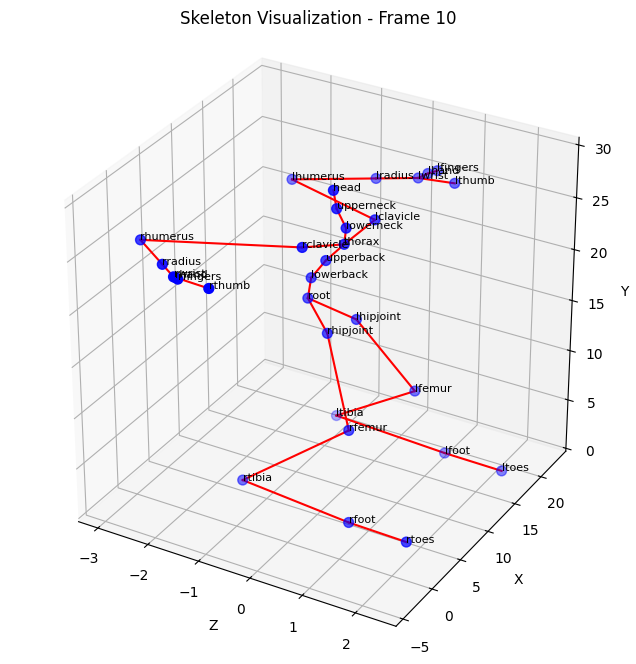

In [11]:
visualize_skeleton(joints2, show_labels=True, motion_data=motions2, motion_frame=10)

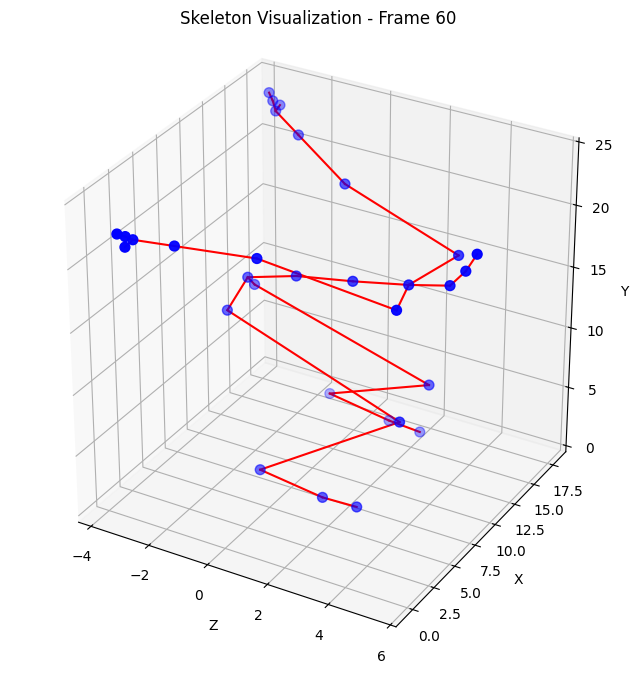

In [12]:
visualize_skeleton(joints2, motion_data=motions2, motion_frame=60)

We can see here the posture before the burst (jump) from the 2 Subject for a vertical jump.

## 3- Skeleton 3D Animation

We will here try to create an interactive 3D animation of motion capture data. 

The function `create_3d_animation`:
- Visualizes skeleton movement through a specified frame range
- Provides smooth playback with adjustable speed
- Maintains proper bone/joint connections
- Auto-scales viewport to contain all motion

 🛠 **Parameters**

| Parameter | Type | Description |
|-----------|------|-------------|
| `joints` | dict | Parsed skeleton hierarchy (must contain 'root' joint) |
| `motions` | list | Motion data frames from AMC file |
| `start_frame` | int | First frame to include (default: 0) |
| `end_frame` | int | Last frame to include (None = all frames) |

In [8]:
# helper function for the update function in create_3d_animation and later on for motion 
def update_3d_scene(joints, motions, frame_idx, scat, lines, ax):
    joints['root'].set_motion(motions[frame_idx])
    joint_dict = joints['root'].to_dict()

    coords = np.array([
        [j.coordinate[2, 0], j.coordinate[0, 0], j.coordinate[1, 0]] # Order: Z, X, Y
        for j in joint_dict.values()
    ])
    scat._offsets3d = (coords[:, 0], coords[:, 1], coords[:, 2])

    line_idx = 0
    for j in joint_dict.values():
        if j.parent and line_idx < len(lines):
            jc, pc = j.coordinate[:, 0], j.parent.coordinate[:, 0]
            x, y, z = [jc[2], pc[2]], [jc[0], pc[0]], [jc[1], pc[1]]
            lines[line_idx].set_data(x, y)
            lines[line_idx].set_3d_properties(z)
            line_idx += 1

    padding = 20
    ax.set_xlim(np.min(coords[:, 0]) - padding, np.max(coords[:, 0]) + padding)
    ax.set_ylim(np.min(coords[:, 1]) - padding, np.max(coords[:, 1]) + padding)
    ax.set_zlim(np.min(coords[:, 2]) - padding, np.max(coords[:, 2]) + padding)

In [14]:
def create_3d_animation(joints, motions, start_frame=0, end_frame=None):
    
    if end_frame is None or end_frame > len(motions):
        end_frame = len(motions)
    frames_to_show = range(start_frame, end_frame)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scat = ax.scatter([], [], [], c='b', s=50)
    lines = [ax.plot([], [], [], 'r-')[0] for _ in range(20)]

    ax.set_xlabel('Z')
    ax.set_ylabel('X')
    ax.set_zlabel('Y')
    ax.set_title('3D Motion Capture Animation')

    def update(i):
        update_3d_scene(joints, motions, i, scat, lines, ax)
        return [scat] + lines

    ani = animation.FuncAnimation(
        fig, update, frames=len(frames_to_show),
        interval=50, blit=True
    )

    plt.close()
    return HTML(ani.to_jshtml())

In [ ]:
create_3d_animation(joints1, motions1, start_frame=500, end_frame=700)

In [ ]:
create_3d_animation(joints1, motions1, start_frame=0, end_frame=700)

In [ ]:
create_3d_animation(joints2, motions2, start_frame=0, end_frame=300)

## 4- Movement Video Display

In [ ]:
def show_mpeg_animation_simple(video_path, max_frames=100):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened() and len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()

    fig, ax = plt.subplots()
    im = ax.imshow(frames[0])
    ax.axis('off')

    def update(i):
        im.set_array(frames[i])
        return im,

    ani = FuncAnimation(fig, update, frames=len(
        frames), interval=100, blit=True)
    plt.close()
    return HTML(ani.to_jshtml())


### 4.1- Subject 1 Trial 1 Video

In [ ]:
show_mpeg_animation_simple(mpeg_path1, max_frames=500)

### 4.2- Subject 2 Trial 4 Video

In [ ]:
show_mpeg_animation_simple(mpeg_path2, max_frames=200)

---

## 5- Motion Dashboard

To build the motion dashboard, we needed to simultaneously visualize three key components—3D skeleton movement, original video footage, and time series data—alongside interactive widgets for testing and navigation.

We organized the implementation into a set of core functions, grouped as follows:

**Video Loading & Frame Capture**
- `load_video_frames`: loads and stores video frames from the .mpg file
- `init_video_plot`: initializes the video display subplot

**3D Skeleton Visualization**
- `init_3d_plot`: sets up the 3D skeleton plot and bone connections
- `create_animation`: animates the skeleton movement across frames

**Time Series Plotting**
- `extract_time_series_data`: extracts marker positions across time
- `plot_time_series`: visualizes x, y, z position traces with color-coded lines

**Motion Dashboard Assembly**
- `setup_figure`: creates the layout for all three subplots
- `display_controls`: configures interactive playback widgets
- `create_mocap_dashboard`: the main wrapper function that brings all components together


In [9]:
%matplotlib widget

### 5.1- Video Plot

In [10]:
# initialize the video and its frames
def init_video_plot(axV, video_frames):
    blank = np.zeros((100,100,3), dtype=np.uint8)
    
    return axV.imshow(video_frames[0] if video_frames else blank)

def load_video_frames(video_path, max_frames):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened() and len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret: break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    return frames

### 5.2- Skeleton Plot

In [11]:
def init_3d_plot(ax3, joints):
    scat = ax3.scatter([], [], [], c='b', s=50)
    lines = [ax3.plot([], [], [], 'r-')[0] for _ in range(20)]
    return scat, lines

def create_animation(fig, frames, joints, motions, video_frames,
                     scat, lines, video_img, frame_line, ax3):
    def update(i):
        update_3d_scene(joints, motions, frames[i], scat, lines, ax3)
        if i < len(video_frames):
            video_img.set_array(video_frames[i])
        frame_line.set_xdata([i, i])
        fig.canvas.draw_idle()
    ani = FuncAnimation(fig, update, frames=len(frames), interval=50, blit=False)
    return ani, update

### 5.3- Timeseries Plot

In [12]:
def extract_time_series_data(joints, motions, frames, selected):
    ts = {m:{'x':[], 'y':[], 'z':[]} for m in selected}
    for f in frames:
        joints['root'].set_motion(motions[f])
        jd = joints['root'].to_dict()
        for m in selected:
            if m in jd:
                x,y,z = jd[m].coordinate[:,0]
                ts[m]['x'].append(x); ts[m]['y'].append(y); ts[m]['z'].append(z)
    return ts

def plot_time_series(axT, ts_data, selected):
    colors = plt.cm.tab10.colors
    for i,m in enumerate(selected):
        axT.plot(ts_data[m]['x'], '-',  color=colors[i], label=f'{m} X')
        axT.plot(ts_data[m]['y'], '--', color=colors[i], label=f'{m} Y')
        axT.plot(ts_data[m]['z'], ':',  color=colors[i], label=f'{m} Z')
    axT.legend(loc='upper right')
    line = axT.axvline(0, color='k', linestyle='--', alpha=0.5)
    return line

### 5.4- Main Mocap Dashboard Function

In [13]:
def setup_figure():
    plt.close('all')
    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[2,1])
    ax3 = fig.add_subplot(gs[0,0], projection='3d')
    axV = fig.add_subplot(gs[0,1])
    axT = fig.add_subplot(gs[1,:])
    ax3.set_title('3D Skeleton Animation')
    axV.set_title('Original Video')
    axT.set_title('Marker Position Time Series')
    ax3.set_xlim(-100,100); ax3.set_ylim(-100,100); ax3.set_zlim(0,200)
    out = widgets.Output()
    return fig, ax3, axV, axT, out

def display_controls(fig, ani, frames, out, update_func):
    play = widgets.Play(value=0, min=0, max=len(frames)-1,
                        step=1, interval=50, description='Play')
    slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1,
                               description='Frame:')
    widgets.jslink((play, 'value'), (slider, 'value'))

    def on_slider_change(change):
        ani.event_source.stop() 
        update_func(change['new'])

    slider.observe(on_slider_change, names='value')
    
    display(widgets.VBox([widgets.HBox([play, slider]), out]))

def create_mocap_dashboard(video_path, joints, motions,
                           selected_markers=['head','left_hand','right_hand'],
                           start_frame=0, end_frame=None):
    if end_frame is None or end_frame>len(motions):
        end_frame = len(motions)
        
    frames = list(range(start_frame, end_frame))
    video_frames = load_video_frames(video_path, len(frames))
    assert len(video_frames) == len(frames), "Video/motion frame count mismatch"
    
    fig, ax3, axV, axT, out = setup_figure()
    
    scat, bones = init_3d_plot(ax3, joints)
    vimg = init_video_plot(axV, video_frames)
    ts = extract_time_series_data(joints, motions, frames, selected_markers)
    frame_line = plot_time_series(axT, ts, selected_markers)
    ani, update_func = create_animation(fig, frames, joints, motions, video_frames,scat, bones, vimg, frame_line, ax3)
    
    display_controls(fig, ani, frames, out, update_func)
    return ani

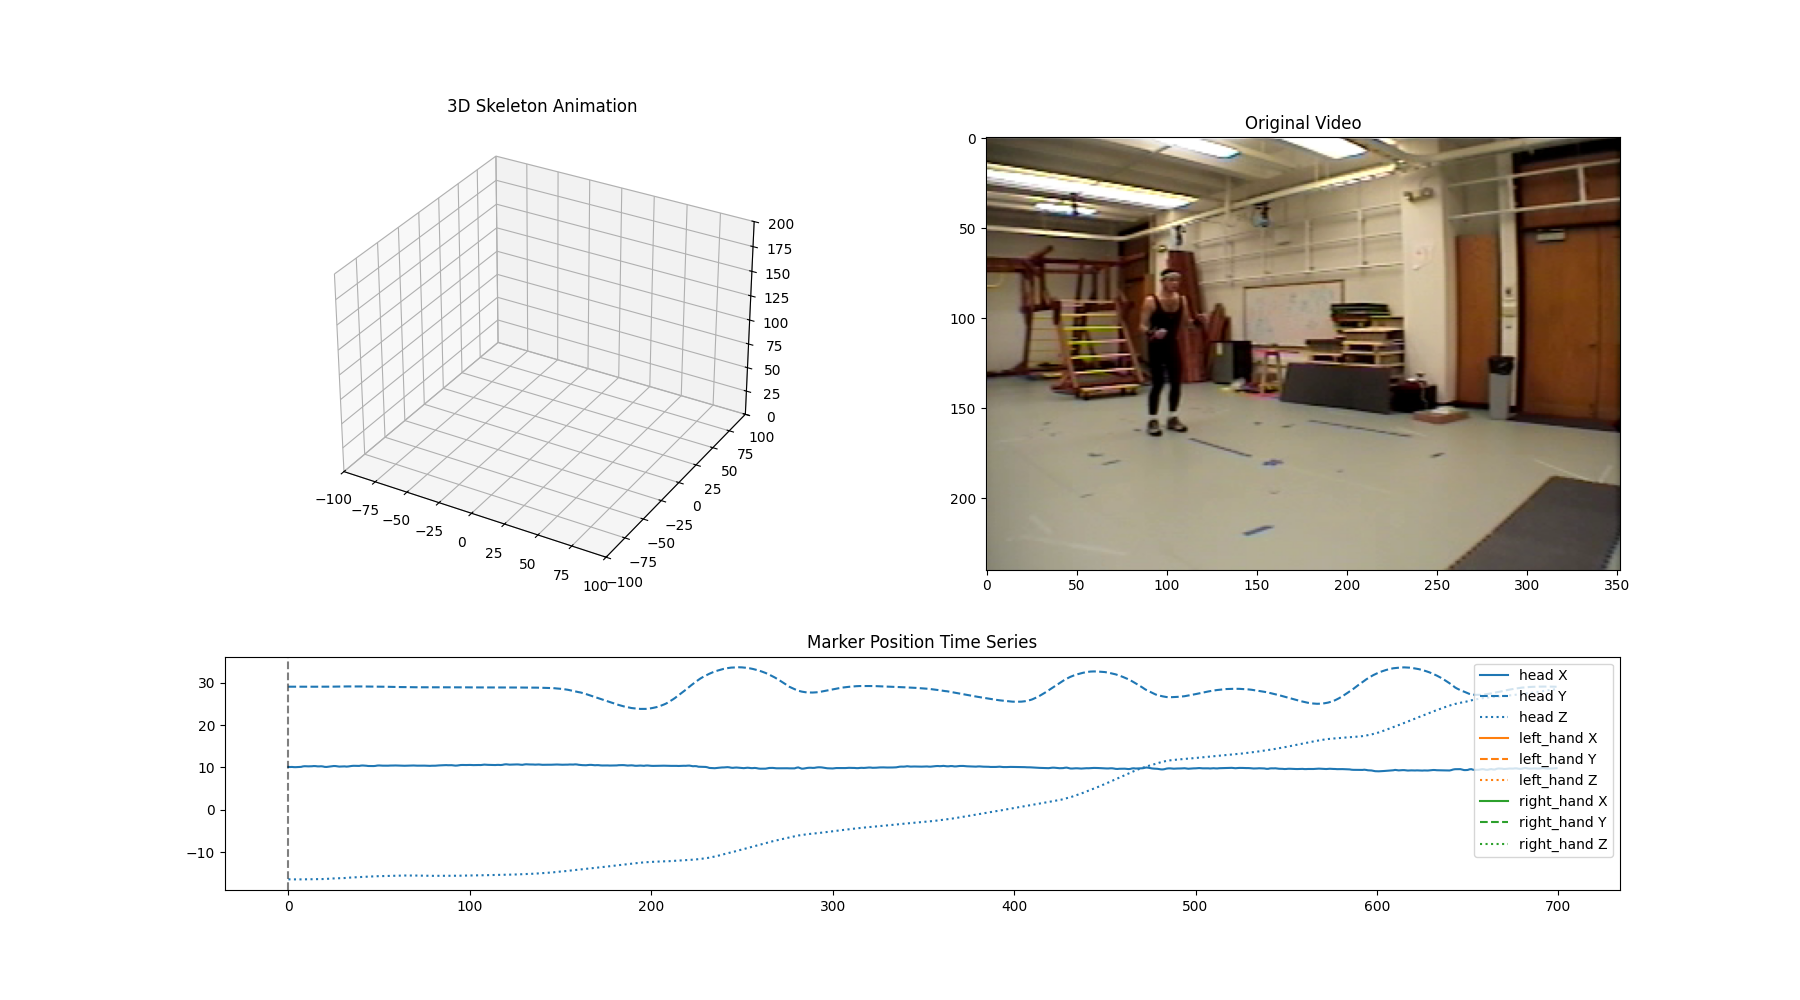

In [14]:
dashboard = create_mocap_dashboard(
    video_path=mpeg_path1,
    joints=joints1,
    motions=motions1,
    start_frame=0,
    end_frame=700,
)